<a href="https://colab.research.google.com/github/Topolewski-Kamil/dKnn/blob/main/base_looks_good_works_even_better.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep k-Nearest Neighbours**

In this project, the Deep k-Nearest Neighbour is examined, a hybrid classifier of Neural Network with k-nearest neighbour algorithm that estimates the nonconformity of predictions. Novel contributions are proposed, which improve its performance, widen possibilities and adapt to real-life applications.

Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/disseration

Import modules

In [ ]:
%tensorflow_version 2.x

## version for plotting bar labels (unstable)
# !pip install matplotlib --upgrade 

## version for the rest of plots (stable)
# !pip install matplotlib==3.1.3 

# Standard python libraries
import numpy as np
import string
import copy
from bisect import bisect_left
import pickle
import matplotlib.pyplot as plt

# tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K
from keras.models import load_model, Sequential
from keras.losses import MSE
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

# approximate nearest neighbours libraries
!pip install pynndescent
!pip install falconn
!pip install annoy
!pip install faiss-gpu
import faiss
import pynndescent
import falconn
import annoy

In [ ]:
def save_pickle(save_object, filename):
  with open(filename, 'wb') as f:
    pickle.dump(save_object, f)

def load_pickle(filename):
  with open(filename, 'rb') as f:
    loaded_object = pickle.load(f)
    return loaded_object

Import and preprocess MNIST dataset

In [ ]:
# number of classes
num_classes = 10 

# input shape of images fed into CNN
input_shape = (28, 28, 1)

# import mnist data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale to [0, 1] size
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make images shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# keep raw labels in separate array
y_test_raw = y_test[750:10000]
y_train_raw = y_train
y_cal_raw = y_test[0:750]

# convert labels to one hot enconding
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# split test set into calibration set
x_cal = x_test[0:750] 
y_cal = y_test[0:750]
x_test = x_test[750:10000]
y_test = y_test[750:10000]

# **Model 1** - recreation of N. Papernot and P. McDaniel model 

Initialize CNN model

In [ ]:
#model architechture
model1 = Sequential(
    [
        keras.Input(shape=input_shape),
        Conv2D(64, kernel_size=(8, 8), strides=(2,2), padding='same', activation='relu', input_shape=x_train.shape[1:]),
        Conv2D(128, kernel_size=(6, 6), strides=(2,2), padding='valid', activation='relu'),
        Conv2D(128, kernel_size=(5, 5), strides=(1,1), padding='valid', activation='relu'),
        Flatten(),
        Dense(10, activation=tf.nn.softmax),
    ]
)

batch_size = 500
epochs = 8

adam_opt = keras.optimizers.Adam(learning_rate=0.001)
model1.compile(loss="categorical_crossentropy", optimizer=adam_opt, metrics=["accuracy"])

# number of neigbours used for Aproximate Nearest Neighbour Algorithm
K_NEIGHBOURS = 75

Train and evaluate model

In [ ]:
# try loading model from files
try:
  model1 = load_model('model1_three_lay/model.h5')
  print("loaded model from disc")

# otherwise train from scratch
except OSError:
  print("failed to load model from disc")
  model1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
  # model.save('deepKNN_model_new.h5')  # creates a HDF5 file
    
score = model1.evaluate(x_test, y_test, verbose=0)
print("Test accuracy:", score[1])

# **Model 2** - Experimental

Initialize CNN model

In [ ]:
#model architechture source: https://www.kaggle.com/code/elcaiseri/mnist-simple-cnn-keras-accuracy-0-99-top-1/notebook
model2 = Sequential(
    [
        keras.Input(shape=input_shape),
        Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)),
        Conv2D(filters=64, kernel_size = (3,3), activation="relu"),
        MaxPooling2D(pool_size=(2,2)),
        BatchNormalization(),
     
        Conv2D(filters=128, kernel_size = (3,3), activation="relu"),
        Conv2D(filters=128, kernel_size = (3,3), activation="relu"),
        MaxPooling2D(pool_size=(2,2)),
        BatchNormalization(),   

        Conv2D(filters=256, kernel_size = (3,3), activation="relu"),
        MaxPooling2D(pool_size=(2,2)),
        BatchNormalization(),
            
        Flatten(),
        Dense(512,activation="relu"),
        Dense(10,activation="softmax")
    ]
)

batch_size2 = 500
epochs2 = 8

adam_opt = keras.optimizers.Adam(learning_rate=0.001)
model1.compile(loss="categorical_crossentropy", optimizer=adam_opt, metrics=["accuracy"])

# indexes of layers that will be indexed and used for querying nearest neibouts
neighbours_layers_indexes2 = [2,6,9]
knn_layers_count2 = len(neighbours_layers_indexes2)

# number of neigbours used for Aproximate Nearest Neighbour Algorithm
K_NEIGHBOURS = 75

Train and evaluate model

In [ ]:
# try loading model from files
try:
  model2 = load_model('model2/experiment2/deepKNN_model9947.h5')
  print("loaded model from disc")

# otherwise train from scratch
except OSError:
  print("failed to load model from disc")
  model2.fit(x_train, y_train, batch_size=batch_size2, epochs=epochs2, validation_split=0.1)
  # model2.save('model2/deepKNN_model2.h5')  # creates a HDF5 file
  print("saved model successfully")

score = model2.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# Activations

Get activations for each dataset

In [ ]:
# normalize the activations (improves nearest neighbours time and performance)
def normalize_activations(activations):
  for layer in activations:
    layer /= np.linalg.norm(layer, axis=1).reshape(-1, 1)

# get activations for a dataset
def layers_activations_small(model, dataset, neighbours_layers_indexes):
  activations = []
  for i in neighbours_layers_indexes: # 0,1,2-convolutions layer, 5-dense layer
      layer = model.layers[i]
      lay_act = K.function([model.layers[0].input], [layer.output])([dataset])[0]
      if i != 5: # for conv layers
        activations.append(lay_act.reshape(lay_act.shape[0], lay_act.shape[1]*lay_act.shape[2]*lay_act.shape[3]))
      else:   # for dense layers
        activations.append(lay_act)

  normalize_activations(activations)
  return activations

# get activations for a dataset in chunks (otherwise OOM error)
def layers_activations_big_data(model, dataset, neighbours_layers_indexes):
  activations = []
  for i in neighbours_layers_indexes: # 0,1,2-convolutions layer, 5-dense layer
      layer = model.layers[i]
      lay_act_arr = []
      chunk_size = 10000
      for i in range(0, 10000, chunk_size):
        lay_act = K.function([model.layers[0].input], [layer.output])([dataset[i:i+chunk_size]])[0]
        lay_act_arr = np.array(lay_act)
      for i in range(10000, len(dataset), chunk_size):
        lay_act = K.function([model.layers[0].input], [layer.output])([dataset[i:i+chunk_size]])[0]
        lay_act_arr = np.append(lay_act_arr, lay_act, axis=0)

      activations.append(lay_act_arr.reshape(lay_act_arr.shape[0], lay_act_arr.shape[1]*lay_act_arr.shape[2]*lay_act_arr.shape[3]))

  normalize_activations(activations)
  return activations

# returns activations for all datasets
def datasets_activations(model, model_adv, layers_activations, neighbours_layers_indexes):
  activations_train = layers_activations(model, x_train, neighbours_layers_indexes)

  activations_test = {}
  for eps in model_adv.epsilons:
    activations_test[eps] = layers_activations(model, model_adv.fgsm_adversaries[eps], neighbours_layers_indexes)

  activations_calib = layers_activations(model, x_cal, neighbours_layers_indexes)

  return [activations_train, activations_test, activations_calib]

# Adversarial Examples

In [ ]:
## This class provides functionality for generating adversairial examples
class Adversaries:
  def __init__(self, model, epsilons, folder):
    self.model = model
    self.epsilons = copy.deepcopy(epsilons)
    self.folder = folder
    self.fgsm_adversaries = self.get_adversaries()

  def load_adversaries(self):
    adversaries = {}
    for eps in self.epsilons:
      eps_str = str(eps)
      eps_str = eps_str.translate(str.maketrans('', '', string.punctuation))
      path = self.folder + 'adv_datasets/adversaries' + eps_str  + '.npy'
      adversaries[eps] = np.load(path)
    return adversaries

  # function saving adversarials examples
  def save_adversaries(self, adversaries):
    for eps in self.epsilons:
      eps_str = str(eps)
      eps_str = eps_str.translate(str.maketrans('', '', string.punctuation))
      filename = self.folder + 'adv_datasets/adversaries' + eps_str + '.npy'
      np.save(filename, adversaries[eps])
      print('saved ' + str(eps))

  def generate_single_adversary(self, image, label, eps):

    # Make images shape (1, 28, 28, 1)
    image = tf.cast(image.reshape(1, 28, 28, 1), tf.float32)

    # record our gradients
    with tf.GradientTape() as tape:

      # start tracing image by the Tape
      tape.watch(image)

      #compute prediction
      pred = self.model(image)

      # compute loss
      loss = MSE(label, pred)

      # calculate the gradient of loss function 
      grad = tape.gradient(loss, image)

      # compute the sign of the gradient
      sign = tf.sign(grad)

      # create perturbation
      perturbation = sign * eps

      # apply perturbation to image
      adversary = (image + perturbation).numpy()

      # Make images shape (28, 28, 1)
      adversary = adversary.reshape(28, 28, 1)
      
      return adversary

  def get_adversaries(self):
    try:
      adversaries = self.load_adversaries()
      self.epsilons.insert(0, 0.0)
      adversaries[0.0] = x_test
      print('loaded adversarial datasets from disc')
    except FileNotFoundError:
      print('failed to load adversarial datasets from disc')
      adversaries = {}
      for eps in self.epsilons:
        adv = []
        for i in range(x_test.shape[0]):
          adv.append(self.generate_single_adversary(x_test[i], y_test[i], eps))
        adversaries[eps] = np.array(adv)
      self.epsilons.insert(0, 0.0)
      adversaries[0.0] = x_test
    return adversaries

  # accuracy of a model with respect to epsilon.
  def plot_accuracy_vs_epsilon(self):
    accuracies_plot = []
    for eps in self.epsilons:
      adversary_score = self.model.evaluate(self.fgsm_adversaries[eps], y_test, verbose=0)
      accuracies_plot.append(adversary_score[1] * 100)
      print(adversary_score)

    plt.figure(figsize=(5,5))
    plt.plot(self.epsilons, accuracies_plot, linestyle='--', marker='o', color='b', label = 'DNN')

    plt.yticks(np.arange(0, 101, step=10))
    plt.xticks(np.arange(0, 0.16, step=0.025))
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epsilon")
    plt.legend()
    plt.show()
    return accuracies_plot

  # plot a subset of adversarial examples with true and predicted labeles
  def plot_adv_examples(self):
    counter = 0
    plt.figure(figsize=(10,15))

    for eps in [0.025, 0.1, 0.15]:
      adv_img = self.fgsm_adversaries[eps][10:15]
      true_label = y_test[10:15]

      adv_results = model1.predict(self.fgsm_adversaries[eps][10:15])
      predicted_labels = []
      for result in adv_results:
        predicted_labels.append(np.argmax(result))

      for i in range(5):
          counter += 1
          plt.subplot(len(self.epsilons), 5, counter)
          plt.xticks([], [])
          plt.yticks([], [])

          if i == 0:
            plt.ylabel(r'$\bf{Eps: '+ str(eps) + '}$', fontsize=14)

          label = np.argmax(true_label[i])
          if predicted_labels[i] != label:
            incorrect_label = plt.title('Pred. label: ' + str(predicted_labels[i]))
            plt.setp(incorrect_label, color='r')
          else:
            if eps == 0.025:
              plt.title(r'$\bf{' + 'True label:' + str(label) + '}$' + '\n\nPred. label:' + str(predicted_labels[i]))
            else:
              plt.title('Pred. label: ' + str(predicted_labels[i]))

          plt.imshow(np.squeeze(adv_img[i]), cmap='gray')
    plt.show()

# PyNNDescent

In [ ]:
# class providing implementation of PyNNDescent library
# library url: https://github.com/lmcinnes/pynndescent
class PyNND:
  def __init__(self, model, activations_ttc, neighbours_layers_indexes, epsilons, folder):
    self.model = model
    self.neighbours_layers_indexes = neighbours_layers_indexes
    self.activations_train = activations_ttc[0]
    self.activations_test = activations_ttc[1]
    self.activations_calib = activations_ttc[2]
    self.knn_layers_count = len(neighbours_layers_indexes)
    self.epsilons = epsilons
    self.folder = folder
    self.knn_eps = 0.1

    index_act = self.index_layer()
    self.neighbours_test = self.find_neighbours_test(index_act)
    self.neighbours_calib = self.find_neighbours_calib(index_act)

  # index training data activations
  def index_layer(self):
    try: 
        index_act = load_pickle(self.folder + 'pynnd/neighbours_index.pkl')
        print('loaded neighbours index from disc')
    except FileNotFoundError:
        print('failed to load neighbours index from disc')
        index_act = {}
        for layer in range(self.knn_layers_count):
          index_act[layer] = pynndescent.NNDescent(self.activations_train[layer]) # index training data
          index_act[layer].prepare() # prepare for faster query
    return index_act

  # uses a set of activations to query the index for neighbours
  def query_index(self, index, activations):
    neighbours = index.query(activations, k=K_NEIGHBOURS, epsilon=self.knn_eps)
    neighbours_labels = y_train_raw[neighbours[0]]
    return neighbours_labels

  # find neighbours for the test set
  def find_neighbours_test(self, index):
    try:
      neighbours = load_pickle(self.folder + 'pynnd/neighbours.pkl')
      print('loaded neighbours from disc')
    except FileNotFoundError:
      print('failed to load neighbours from disc')
      neighbours = {}
      for layer in range(self.knn_layers_count):
        neighbours[layer] = {}
        for eps in self.epsilons:
          neighbours[layer][eps] = self.query_index(index[layer], self.activations_test[eps][layer])
    return neighbours

  # find neighbours for the calibration set
  def find_neighbours_calib(self, index):
    neigbours_calib = {}
    for layer in range(self.knn_layers_count):
      neigbours_calib[layer] = self.query_index(index[layer], self.activations_calib[layer])
    return neigbours_calib

# Annoy

In [ ]:
# class providing implementation of Annoy library
# library url: https://github.com/spotify/annoy
class Annoy:
  def __init__(self, model, activations_ttc, neighbours_layers_indexes, epsilons, folder):
    self.model = model
    self.neighbours_layers_indexes = neighbours_layers_indexes
    self.activations_train = activations_ttc[0]
    self.activations_test = activations_ttc[1]
    self.activations_calib = activations_ttc[2]
    self.epsilons = epsilons
    self.folder = folder

    self.knn_layers_count = len(neighbours_layers_indexes)

    index_act = self.index_layer()
    self.neighbours_test = self.find_neighbours_test(index_act)
    self.neighbours_calib = self.find_neighbours_calib(index_act)

  # built-in annoy save function allowing static querying
  def save_annoy_index(self, neighbours):
    for layer in range(self.knn_layers_count):
      neighbours[layer].save(self.folder + 'annoy/index/annoy_index_' + str(layer) + '.ann')

  def load_annoy_index(self):
    index_act = {}
    for layer in range(self.knn_layers_count):
      index_act[layer] = annoy.AnnoyIndex(self.activations_train[layer].shape[1], 'angular')
      index_act[layer].load(self.folder +'annoy/index/annoy_index_' + str(layer) + '.ann')
    return index_act

  def load_annoy_neighbours(self):
    neighbors_annoy = {}
    for layer in range(knn_layers_count):
      neighbors_annoy[layer] = load_pickle(self.folder + 'annoy/neighbours/neighbours_annoy_layer_' + str(layer + 1) + '.pkl')
      for eps in self.epsilons:
        neighbors_annoy[layer][eps] = y_train_raw[neighbors_annoy[layer][eps]]
    return neighbors_annoy
  
  # index training data activations
  def index_layer(self):
    try: 
      index_act = self.load_annoy_index()
      print('loaded annoy index successfully')
    except OSError:
      print('failed to load neighbours index from disc')
      index_act = {}
      for layer in range(self.knn_layers_count):
        index_act[layer] = annoy.AnnoyIndex(self.activations_train[layer].shape[1], 'angular')

      for layer in range(self.knn_layers_count):
        for i in range(self.activations_train[layer].shape[0]):
          index_act[layer].add_item(i, self.activations_train[layer][i])
        index_act[layer].build(50) # build 50 trees
    return index_act

  # find neighbours for the test set
  def find_neighbours_test(self, index):
    try:
      neighbours = self.load_annoy_neighbours()
      print('loaded annoy neighbours')
    except OSError:
      print('failed to loaded annoy neighbours')
      neighbours = {}
      for layer in range(self.knn_layers_count):
        neighbours[layer] = {}
        for eps in self.epsilons:
          arr = []
          for act in self.activations_test[eps][layer]:
            indexes = index[layer].get_nns_by_vector(act, K_NEIGHBOURS)
            arr.append(y_train_raw[indexes])
          neighbours[layer][eps] = np.array(arr)
    return neighbours

  # find neighbours for the calibration set
  def find_neighbours_calib(self, index):
    neigbours_cal = {}
    for layer in range(self.knn_layers_count):
      arr = []
      for act in self.activations_calib[layer]:
        calib_indexes = index[layer].get_nns_by_vector(act, K_NEIGHBOURS)
        arr.append(y_train_raw[calib_indexes])
      neigbours_cal[layer] = np.array(arr)
    return neigbours_cal

# Falconn

In [ ]:
# class providing implementation of Falconn library
# library url: https://github.com/FALCONN-LIB/FALCONN
class Falconn:
  def __init__(self, model, activations_ttc, neighbours_layers_indexes, epsilons, folder):
    self.model = model
    self.neighbours_layers_indexes = neighbours_layers_indexes
    self.activations_train = activations_ttc[0]
    self.activations_test = activations_ttc[1]
    self.activations_calib = activations_ttc[2]
    self.epsilons = epsilons
    self.folder = folder
    self.knn_layers_count = len(neighbours_layers_indexes)
    self.number_of_tables = 50

    index_act, center_arr = self.index_layers()
    self.neighbours_test = self.find_neighbours_test(index_act, center_arr)
    self.neighbours_calib = self.find_neighbours_calib(index_act)

  # index training data activations for a single layer
  def index_single_layer(self, act, center):
    params_cp = falconn.LSHConstructionParameters()
    params_cp.dimension = len(act[0])
    params_cp.lsh_family = falconn.LSHFamily.CrossPolytope
    params_cp.distance_function = falconn.DistanceFunction.EuclideanSquared
    params_cp.l = self.number_of_tables
    params_cp.num_rotations = 1
    params_cp.seed = 5721840
    params_cp.num_setup_threads = 0
    params_cp.storage_hash_table = falconn.StorageHashTable.BitPackedFlatHashTable
    falconn.compute_number_of_hash_functions(18, params_cp)
    table = falconn.LSHIndex(params_cp)
    table.setup(act - center)
    query_object = table.construct_query_object()

    return query_object

  # index training data activations
  def index_layers(self):
    index_act = {}
    center_arr = []
    for layer in range(self.knn_layers_count):
      center = np.mean(self.activations_train[layer], axis=0)
      center_arr.append(center)
      index_act[layer] = self.index_single_layer(self.activations_train[layer], center)
    return index_act, center_arr

  # uses a set of activations to query the index for neighbours
  def query_index(self, index, activations, center):
    closest_labels = []
    for (_, query) in enumerate(activations - center):
        neighbours = index.find_k_nearest_neighbors(query, 75)
        labels = y_train_raw[neighbours]
    return np.array(labels)

  # find neighbours for the test set
  def find_neighbours_test(self, index, center_arr):
    try:
      neighbours = load_pickle(self.folder + 'lsh/neighbours_lsh_new.pkl')
      print('loaded neighbours from disc')
    except FileNotFoundError:
      print('failed to load neighbours index from disc')
      neighbours = {}
      for layer in range(self.knn_layers_count):
        neighbours[layer] = {}
        for eps in self.epsilons:
          neighbours[layer][eps] = self.query_index(index[layer], self.activations_test[eps][layer], center_arr[layer])
    return neighbours

  # find neighbours for the calibration set
  def find_neighbours_calib(self, index):
    neigbours_cal = {}
    for layer in range(self.knn_layers_count):
      center = np.mean(self.activations_calib[layer], axis=0)
      neigbours_cal[layer] = self.query_index(index[layer], self.activations_calib[layer], center)

    return neigbours_cal

# DkNN

In [ ]:
# class providing implementation of DkNN algorithm
class DkNN:
  def __init__(self, ann_object):
    self.model = ann_object.model
    self.neighbours_test = ann_object.neighbours_test
    self.neighbours_calib = ann_object.neighbours_calib
    self.knn_layers_count = ann_object.knn_layers_count
    self.epsilons = ann_object.epsilons

    nonconformity_calib = self.calibrate_nonconformity()
    self.p_values, self.knn_predicted_labels = self.calculate_performance_parameters(nonconformity_calib)

    for eps in self.epsilons:
      self.plot_reliability('DkNN', eps, p_values[eps])

  # Returns how many neighbours does not match real label
  def count_not_matching_labels(self, neihgbours_arr):
    nonconformity = []
    for i in range(0, neihgbours_arr.shape[0]):
      incorrect = np.sum(neihgbours_arr[i] != y_cal_raw[i])
      nonconformity.append(incorrect)

    return np.array(nonconformity)

  # calibtrates the noncoformity of th calibration set
  def calibrate_nonconformity(self):
    nonconformity_calib = np.zeros(self.neighbours_calib[0].shape[0])
    for layer in range(self.knn_layers_count):
      nonconformity_calib += self.count_not_matching_labels(self.neighbours_calib[layer])

    # sort
    nonconformity_calib =  np.sort(nonconformity_calib)
    # trim zeros
    nonconformity_calib = np.trim_zeros(nonconformity_calib, trim='f')

    return nonconformity_calib

  # calculate_nonconformity for each class based on calibration
  def calculate_nonconformity(self, eps):
    nonconformity_for_class = np.full((x_test.shape[0], num_classes), K_NEIGHBOURS * self.knn_layers_count, dtype=np.float32)
    for i in range(x_test.shape[0]):
      for layer in range(self.knn_layers_count):
        for neighbour in self.neighbours_test[layer][eps][i]:
          nonconformity_for_class[i][neighbour] -= 1

    return nonconformity_for_class

  # calculate empirival p-values
  def calculate_p_values(self, nonconformity_for_class, nonconformity):
    p_values = np.empty((x_test.shape[0], num_classes),  dtype=np.float32)
    for i in range(x_test.shape[0]):
      for j in range(num_classes):
        insert_index = bisect_left(nonconformity, nonconformity_for_class[i][j])
        p_values[i][j] = (nonconformity.shape[0] - insert_index) / nonconformity.shape[0]
    return p_values

  # DkNN labels predictions based on p-values
  def predict_labels(self, nonconformity_for_class):
    knn_predicted_labels = []
    for i in range(x_test.shape[0]):
      knn_predicted_labels.append(np.argmin(nonconformity_for_class[i]))
    return np.array(knn_predicted_labels)

  def calculate_performance_parameters(self, nonconformity_calib):
    nonconformity_for_class = {}
    p_values = {}
    knn_predicted_labels = {}
    for eps in self.epsilons:
      nonconformity_for_class = self.calculate_nonconformity(eps)
      p_values[eps] = self.calculate_p_values(nonconformity_for_class, nonconformity_calib)
      knn_predicted_labels[eps] = self.predict_labels(nonconformity_for_class)
    return p_values, knn_predicted_labels

  # function returning bin sizes for plotting realiability diagram
  def calculate_performance_per_cred(self, confidence, predicted_labels):
    credibility = np.max(confidence, axis=1)
    distribution = np.zeros(10)
    correct_labels = np.zeros(10)

    for i in range(credibility.shape[0]):
      bin = credibility[i] // 0.1 / 10
      bin_index = int(bin*10)
      distribution[bin_index] += 1
      if (predicted_labels[i] == y_test_raw[i]):
        correct_labels[bin_index] += 1

    for i in range(correct_labels.shape[0]):
      if correct_labels[i] != 0 and distribution[i] != 0:
        correct_labels[i] /=  distribution[i]

    return distribution, correct_labels 

  # funtion ploting realiabilit diagram (accuracy in respect to credibility)
  def plot_reliability(self, model_type, eps, confidence):

    if model_type == 'Softmax':
      softmax_probabilities = self.model.predict(model1adv.fgsm_adversaries[eps])
      softmax_classes = softmax_probabilities.argmax(axis=-1)
      confidence = softmax_probabilities
      num_points, reliability_diag = self.calculate_performance_per_cred(confidence, softmax_classes)
      print(np.array(num_points))
      print(np.array(reliability_diag))
    else:
      num_points, reliability_diag = self.calculate_performance_per_cred(confidence, self.knn_predicted_labels[eps])
      print(np.array(num_points))
      print(np.array(reliability_diag))

    bars_begin = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    bars_end = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    bars_center = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95]

    fig, ax1 = plt.subplots()
    p1 = ax1.bar(bars_center, np.round(reliability_diag*100, 1), width=10, alpha=0.8, edgecolor = "black")

    ax2 = ax1.twinx()
    ax2.plot(bars_center, num_points, color='r', linestyle='-', linewidth=6.0)
    ax1.set_ylim([0, 100])

    plt.title("Reliability Diagram: " + model_type + ', eps: ' + str(eps))
    ax2.set_ylabel('Number of points in dataset', color='r')
    if model_type == 'Softmax':
      ax1.set_xlabel('Prediction Confidence %')
    else:
      ax1.set_xlabel('Prediction Credibility %')

    ax1.set_ylabel('Prediction Accuracy %')
    ax2.tick_params(colors='r')
    plt.show()

  # evaluate models accuracy
  def test_model_accuracy(self, eps):
    correct_labels = np.sum(self.knn_predicted_labels[eps] == y_test_raw)
    return correct_labels / len(self.knn_predicted_labels[eps]) * 100

  # merge evaluations of different models
  def accuracy_per_model(self):
    accuracies_plot_knn = []
    for eps in self.epsilons:
      model_accuracy = self.test_model_accuracy(eps)
      accuracies_plot_knn.append(model_accuracy)
    return accuracies_plot_knn

  # count correct neighbours's labels
  def correct_neighbours_count(self, neighbours):
    correct_neighbours = [0] * (K_NEIGHBOURS + 1)
    for i in range(0, neighbours.shape[0]):
      correct = np.sum(neighbours[i] == y_test_raw[i])
      correct_neighbours[correct] += 1
    return correct_neighbours

  # plot corectness of neighbours's labels
  def compare_neigbours(self, layer, eps):
    correct_neighbours = self.correct_neighbours_count(self.neighbours_test[layer][0.0])
    correct_neighboursAdv = self.correct_neighbours_count(self.neighbours_test[layer][eps])

    plt.figure(figsize=(12,5))
    x_ax = np.arange(len(correct_neighbours))
    plt.bar(x_ax-0.2, correct_neighboursAdv, 0.4, label = 'Epsilon: 0.0')
    plt.bar(x_ax+0.2, correct_neighboursAdv, 0.4, label = 'Epsilon: ' + str(eps))

    plt.xlabel("Correct neighbours (out of 75)")
    plt.ylabel("Number of correct neigbours")
    plt.title("Number of correct neigbours on layer number: " + str(layer+1))
    plt.legend()
    plt.xticks(x_ax);
    plt.show()

# **Test Model 1**

In [ ]:
# initialize which layers to use
neighbours_layers_indexes = [0,1,2]
knn_layers_count = len(neighbours_layers_indexes)

# generate adversaries
model1adv = Adversaries(
    model = model1,
    epsilons = [0.025, 0.05, 0.075, 0.1, 0.125, 0.15],
    folder = 'model1_three_lay/')

# plot accuracy of model on adversarial examples
model1adv.plot_accuracy_vs_epsilon()

# get layers' activations
activations_ttc = datasets_activations(model1, model1adv, layers_activations_small, neighbours_layers_indexes)

# # index and find neihbours (use below for differen k-NN algorithms)
# pynnd_m1 = Falconn(
# pynnd_m1 = Annoy(
pynnd_m1 = PyNND(    
    model1,
    activations_ttc,
    neighbours_layers_indexes,
    model1adv.epsilons,
    'model1_three_lay/'
    )

# calcualte credibilites with DkNN
dknn_pynnd_m1 = DkNN(pynnd_m1)

# plot relibility diagram
dknn_pynnd_m1.plot_reliability('DkNN', 0.15, dknn_pynnd_m1.p_values[0.15])

# plot its accuracy vs standard DNN
accuracies_plot_knn = dknn_pynnd_m1.accuracy_per_model()
model1adv.plot_accuracy_vs_epsilon()
plt.plot([0.0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15], accuracies_plot_knn, linestyle='--', marker='^', color='r', label = 'DkNN - NND')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


# **Evaluate model 2**

In [ ]:
# initialize which layers to use
neighbours_layers_indexes2 = [3,7,10]

# generate adversaries
model2adv = Adversaries(
    model = model2,
    epsilons = [0.025, 0.05, 0.075, 0.1, 0.125, 0.15],
    folder = 'model2/experiment2/')

# get layers' activations
activations_ttc2 = datasets_activations(
    model2,
    model2adv, 
    layers_activations_big_data, 
    neighbours_layers_indexes2)

# index and find neihbours
pynnd_m1 = PyNND(
    model2,
    activations_ttc2,
    neighbours_layers_indexes2,
    model2adv.epsilons,
    'model2/experiment21/'
    )

# calcualte credibilites with DkNN
dknn_pynnd_m1 = DkNN(pynnd_m1)

# plot relibility diagram
dknn_pynnd_m1.plot_reliability('DkNN', 0.15, dknn_pynnd_m1.p_values[0.15])

# plot its accuracy vs standard DNN
accuracies_plot_knn = dknn_pynnd_m1.accuracy_per_model()
model1adv.plot_accuracy_vs_epsilon()
plt.plot([0.0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15], accuracies_plot_knn, linestyle='--', marker='^', color='r', label = 'DkNN - NND')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


loaded adversarial datasets from disc


Compare models

[0.0319247804582119, 0.9911351203918457]
[0.16109783947467804, 0.9548107981681824]
[0.5666398406028748, 0.8459459543228149]
[1.437364935874939, 0.6385945677757263]
[2.777587652206421, 0.401405394077301]
[4.349267482757568, 0.23243242502212524]
[5.933675765991211, 0.12551350891590118]
[0.02564595453441143, 0.9947026968002319]
[0.09060890227556229, 0.9824864864349365]
[0.26292628049850464, 0.9496216177940369]
[0.6763343811035156, 0.8716756701469421]
[1.4843472242355347, 0.741729736328125]
[2.7148475646972656, 0.5805405378341675]
[4.227595329284668, 0.4243243336677551]


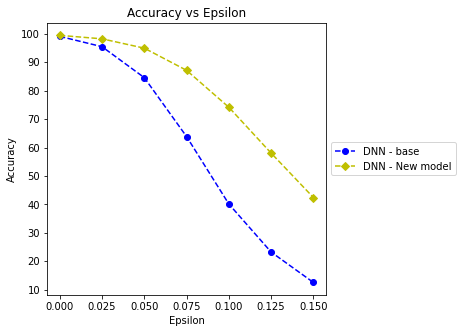

In [ ]:
# accuracies_plot_knn = dknn_pynnd_m1.accuracy_per_model()
model1adv.plot_accuracy_vs_epsilon()
model2adv.plot_accuracy_vs_epsilon2()
# plt.plot([0.0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15], accuracies_plot_knn, linestyle='--', marker='^', color='r', label = 'DkNN')
# print(accuracies_plot_knn)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()